# What is going wrong with squared diagnostics in NeverWorld2

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

FMS diag manager uses "pow2" to compute the time-averages of squared diagnostics. An example is the diagnostic e2 in the averages file. Unfortunately, there are some issues with FMS, which lead to e2 being off by a factor of (72/86400) in 1/4 degree run and (192/86400) in 1/8 degree run. For the curious-minded, the ratio of the two is equal to the ratio of the time-steps in each run (DT = 1200 and DT = 450 respectively, and 1200/450 = 192/72).

In [3]:
run = 20
layer_no = 0
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

In [4]:
sn = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False)
av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [5]:
av

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.049e+04 3.05e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    PV          (time, zl, yq, xq) float32 ...
    dudt        (time, zl, yh, xq) float32 ...
    dvdt        (time, zl, yq, xh) float32 ...
    CAu         (time, zl, yh, xq) float32 ...
    CAv         (time, zl, yq, xh) float32 ...
    rvxu        (time, zl, yq, xh) float32 ...
    rvxv        (time, zl, yh, xq) float32 ...
    gKEu        (time, zl, yh, xq) float32 ...
    gKEv        (time, zl, yq, xh) float32 ...
    PFu         (time, zl, yh, xq) float32 ...
    PFv         (time, zl, yq, xh) float32 ...
    diffu       (time, zl, yh, xq) float32 ...
    diffv       (time, zl, yq, xh) float32 ...
    du_dt_visc  (time, zl, yh, xq) float32 ...
    dv_dt_visc  (time, zl, yq, xh) float32 ...
    u_BT_accel  (time, zl, yh, xq) float32 ...
    v_BT_accel  (time, zl, yq, xh) float32 ...
    KE          (time, zl, yh, xh) float32 ...
    dKE_dt      (time, zl, yh, xh) float32 ...
    PE_to_KE    (time, zl, yh, xh) float32 ...
    KE_BT       (time, zl, yh, xh) float32 ...
    KE_CorAdv   (time, zl, yh, xh) float32 ...
    KE_adv      (time, zl, yh, xh) float32 ...
    KE_visc     (time, zl, yh, xh) float32 ...
    KE_horvisc  (time, zl, yh, xh) float32 ...
    Rd_dx       (time, yh, xh) float32 ...
    Rd1         (time, yh, xh) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00030002.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

Use snapshots to compute the square of e, and compare it to e2 from averages.

In [6]:
xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

In [7]:
h = sn.h.values
H = st.depth_ocean.values
e_temp = sn.h.values.sum(axis=1)

In [8]:
e_temp.shape

(100, 560, 240)

In [9]:
e = e_temp[-1] - H
factor = 24*3/86400
e2 = av.e2.values[-1,layer_no]*factor

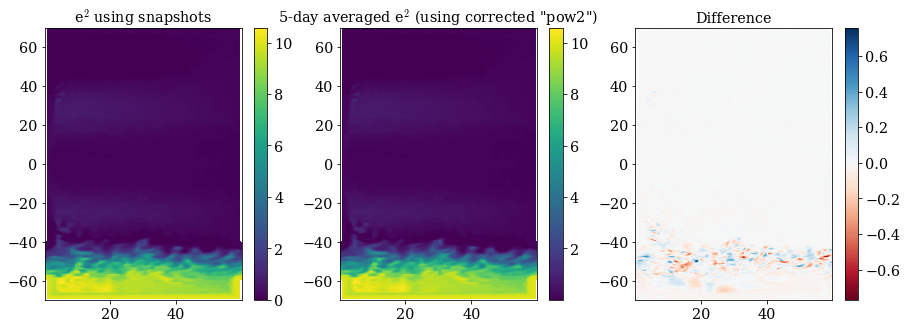

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.pcolormesh(xh,yh,e**2)
plt.colorbar()
plt.title(r'e$^2$ using snapshots')
plt.subplot(1,3,2)
plt.pcolormesh(xh,yh,e2)
plt.colorbar()
plt.title(r'5-day averaged e$^2$ (using corrected "pow2")')
plt.savefig('pow2_error.png', dpi=200,bbox_inches='tight',pad_inches=0)
plt.subplot(1,3,3)
plt.pcolormesh(xh,yh,e**2-e2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
plt.title(r'Difference')
plt.savefig('pow2_error_quarter_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [11]:
np.nanmax(e**2)/np.nanmax(e2)

0.9998109

In [12]:
run = 26
layer_no = 0
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

In [13]:
sn = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False)
av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [14]:
xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

In [15]:
h = sn.h.values
H = st.depth_ocean.values
e_temp = sn.h.values.sum(axis=1)
e = e_temp[-1] - H
factor = 24*8/86400
e2 = av.e2.values[-1,layer_no]*factor

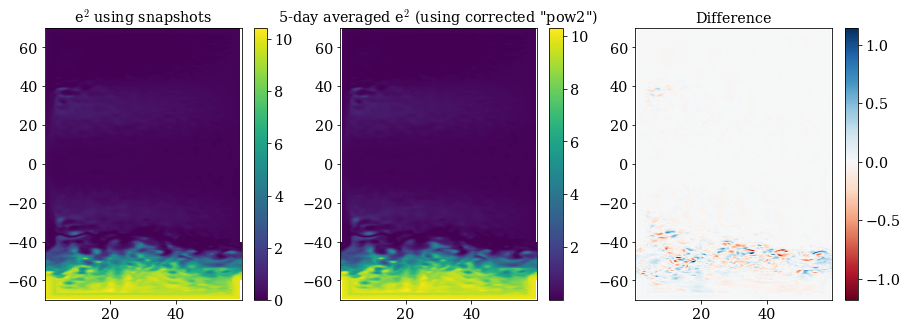

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.pcolormesh(xh,yh,e**2)
plt.colorbar()
plt.title(r'e$^2$ using snapshots')
plt.subplot(1,3,2)
plt.pcolormesh(xh,yh,e2)
plt.colorbar()
plt.title(r'5-day averaged e$^2$ (using corrected "pow2")')
plt.savefig('pow2_error.png', dpi=200,bbox_inches='tight',pad_inches=0)
plt.subplot(1,3,3)
plt.pcolormesh(xh,yh,e**2-e2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
plt.title(r'Difference')
plt.savefig('pow2_error_eighth_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [17]:
run = 28
layer_no = 0
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

In [18]:
sn = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False)
av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [19]:
xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

In [20]:
h = sn.h.values
H = st.depth_ocean.values
e_temp = sn.h.values.sum(axis=1)
e = e_temp[-1] - H
factor = 540/86400
e2 = av.e2.values[-1,layer_no]*factor

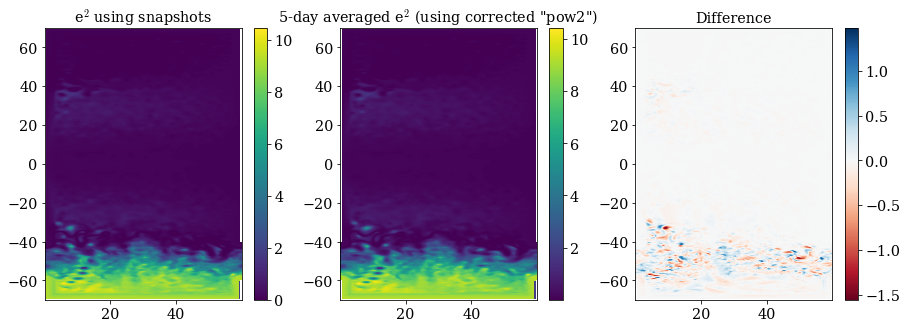

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.pcolormesh(xh,yh,e**2)
plt.colorbar()
plt.title(r'e$^2$ using snapshots')
plt.subplot(1,3,2)
plt.pcolormesh(xh,yh,e2)
plt.colorbar()
plt.title(r'5-day averaged e$^2$ (using corrected "pow2")')
plt.savefig('pow2_error.png', dpi=200,bbox_inches='tight',pad_inches=0)
plt.subplot(1,3,3)
plt.pcolormesh(xh,yh,e**2-e2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
plt.title(r'Difference')
plt.savefig('pow2_error_sixteenth_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [22]:
run = 33
layer_no = 0
tau = 100*86400
end_time = 1500
start_time = end_time - tau/86400

In [23]:
sn = xr.open_dataset('run%i/snapshots_0000%i.nc' % (run, end_time-500+5), decode_times=False)
av = xr.open_dataset('run%i/averages_0000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [24]:
xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

In [25]:
h = sn.h.values
H = st.depth_ocean.values
e_temp = sn.h.values.sum(axis=1)
e = e_temp[-1] - H

In [26]:
factor = 1440/86400
e2 = av.e2.values[-1,layer_no]*factor

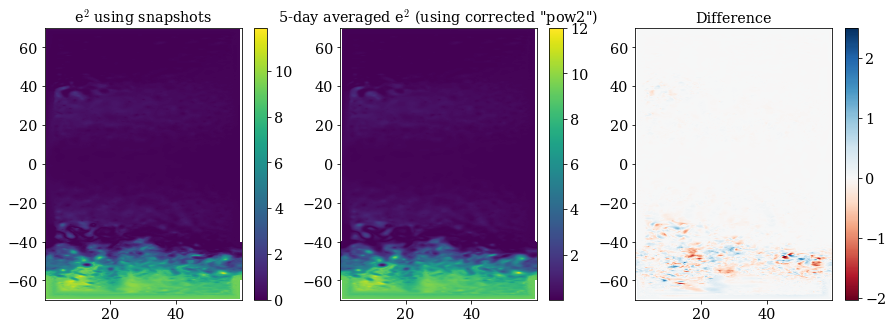

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.pcolormesh(xh,yh,e**2)
plt.colorbar()
plt.title(r'e$^2$ using snapshots')
plt.subplot(1,3,2)
plt.pcolormesh(xh,yh,e2)
plt.colorbar()
plt.title(r'5-day averaged e$^2$ (using corrected "pow2")')
plt.savefig('pow2_error.png', dpi=200,bbox_inches='tight',pad_inches=0)
plt.subplot(1,3,3)
plt.pcolormesh(xh,yh,e**2-e2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()
plt.title(r'Difference')
plt.savefig('pow2_error_thirtysecond_degree.png', dpi=200,bbox_inches='tight',pad_inches=0)